<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/IA353/EF1p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt


data = scipy.io.loadmat('/content/data.mat')
test = scipy.io.loadmat('/content/test.mat')

X = data['X']
S = data['S']

Xt = test['Xt']
St = test['St']

print('X shape: ', X.shape)
print('S shape: ', S.shape)


X shape:  (60000, 784)
S shape:  (60000, 10)


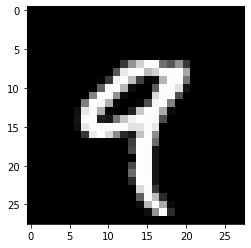

In [2]:
# plot the sample
X_plot = X.reshape(60000, 28, 28)
sample = 4
image = X_plot[sample].T
fig = plt.figure

plt.imshow(image, cmap='gray')
plt.show()

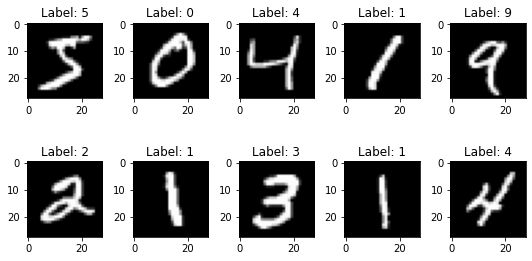

In [3]:
num = 10 # Number of samples to visualize


labels = np.argmax(S, axis=1) + 1
labels = np.where(labels==10, 0, labels)

num_row = 2
num_col = 5
images = X_plot[:num]
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].T, cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Data processing

### Add ones as the first column of X

In [4]:
N, m = X.shape

ones = np.ones((N, 1))

X = np.append(ones, X, axis = 1)

X.shape

(60000, 785)

### Random permutation:

In [5]:
np.random.seed(261663) # Using my RA as seed

new_order = np.random.permutation(N)
X = X[new_order,:]
S = S[new_order,:]

### Holdout:

  1. 80% training
  2. 20% validation

In [6]:
part = 0.8 # Percentage to divide the data

Xtr = X[0:int((part*N)),:]
Xv = X[int((part*N)):N,:]
Str = S[0:int((part*N)),:]
Sv = S[int((part*N)):,:]

N, m = Xtr.shape 
Nv, mv = Xv.shape

print('After Holdout division:')
print('Number of Training samples:', N)
print('Number of Validation samples:', Nv)

After Holdout division:
Number of Training samples: 48000
Number of Validation samples: 12000


In [7]:
p = np.arange(-8, 20, 2, dtype=float)

print(p)
c = 2**(p)
c

[-8. -6. -4. -2.  0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]


array([3.90625e-03, 1.56250e-02, 6.25000e-02, 2.50000e-01, 1.00000e+00,
       4.00000e+00, 1.60000e+01, 6.40000e+01, 2.56000e+02, 1.02400e+03,
       4.09600e+03, 1.63840e+04, 6.55360e+04, 2.62144e+05])

### Crude search for the regularization coefficient:

In [8]:
v_c = []
v_hit_rate_tr = []
v_hit_rate_v = []
hit_rate_max = 0


print('Crude search for the regularization coefficient:')

for p in np.arange(-8, 18, 2, dtype=float):
  C = 2**(p)
  v_c.append(C) # Vector containing every value of crude search

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.dot(np.linalg.inv(np.dot(Xtr.T, Xtr) + C * np.identity(m)), Xtr.T), Str)

  # Training set:
  S_est_tr = np.dot(Xtr, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if S[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr.append(hit_rate_tr)

  # Validation set:
  S_est_v = np.dot(Xv, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max:
    hit_rate_max = hit_rate_v
    c_min = C
    w_min = w


Crude search for the regularization coefficient:


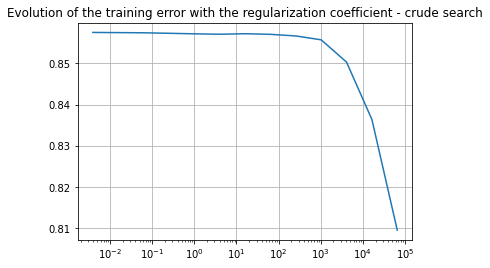

In [9]:
plt.semilogx(v_c, v_hit_rate_tr)
plt.title('Evolution of the training error with the regularization coefficient - crude search')
plt.grid(True)
plt.show()

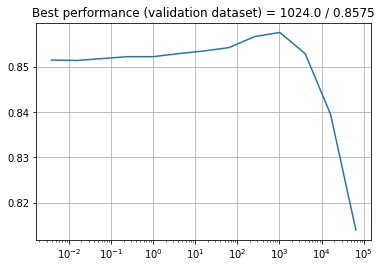

In [10]:
plt.title('Best performance (validation dataset) = {} / {}'.format(c_min, hit_rate_max))
plt.semilogx(v_c, v_hit_rate_v)
plt.grid(True)
plt.show()

### Refined Search:


In [11]:
v_c2 = []
v_hit_rate_tr2 = []
v_hit_rate_v2 = []
hit_rate_max2 = 0

"""
 Given the best crude value for the regularization coeffcient, the refined
 search will consider the interval between the previous and the subsequent
 crude values. 
"""

print('Refined search for the regularization coefficient:')

step = 0.1*(4*c_min-c_min/4)
for p in np.arange(c_min/4, 4*c_min, step, dtype=float):
  C = p
  v_c2.append(C) # Vector containing every value of crude search

  # Regularized least squares (Ridge Regression)
  w = np.dot(np.dot(np.linalg.inv(np.dot(Xtr.T, Xtr) + C * np.identity(m)), Xtr.T), Str)

  # Training set:
  S_est_tr = np.dot(Xtr, w) 
  hit_tr = 0 # To count when the classifier is correct (for every sample)
  for i in range(N):
    indmax = np.argmax(S_est_tr[i,:], axis=0)
    if S[i,indmax] > 0.5:
      hit_tr+=1
  
  hit_rate_tr = hit_tr/N
  v_hit_rate_tr2.append(hit_rate_tr)

  # Validation set:
  S_est_v = np.dot(Xv, w) 
  hit_v = 0 # To count when the classifier is correct (for every sample)
  for i in range(Nv):
    indmax = np.argmax(S_est_v[i,:], axis=0)
    if Sv[i,indmax] > 0.5:
      hit_v+=1
  
  hit_rate_v = hit_v/Nv
  v_hit_rate_v2.append(hit_rate_v)

  if hit_rate_v >= hit_rate_max2:
    hit_rate_max2 = hit_rate_v
    c_min2 = C
    w_min2 = w

Refined search for the regularization coefficient:


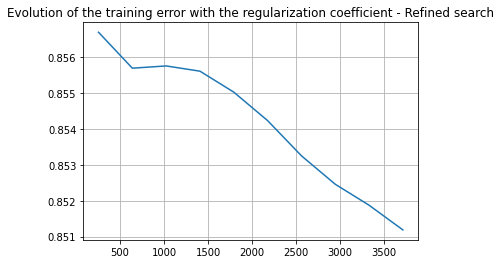

In [12]:
plt.plot(v_c2, v_hit_rate_tr2)
plt.title('Evolution of the training error with the regularization coefficient - Refined search')
plt.grid(True)
plt.show()

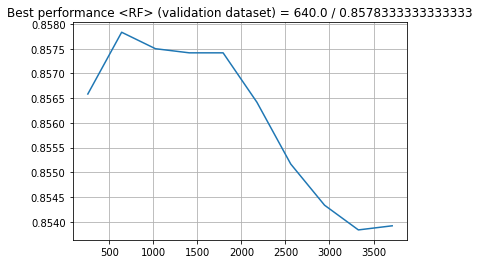

In [13]:
plt.title('Best performance <RF> (validation dataset) = {} / {}'.format(c_min2, hit_rate_max2))
plt.plot(v_c2, v_hit_rate_v2)
plt.grid(True)
plt.show()

In [14]:
Xtot = np.append(Xtr, Xv, axis=0)
Stot = np.append(Str, Sv, axis=0)

w = np.dot(np.dot(np.linalg.inv(np.dot(Xtot.T, Xtot) + C * np.identity(m)), Xtot.T), Stot)

Nt, mt = Xt.shape

ones = np.ones((Nt, 1))
Xt = np.append(ones, Xt, axis = 1)

S_est_t = np.dot(Xt,w)
hit_t = 0

for i in range(Nt):
  indmax = np.argmax(S_est_t[i,:], axis=0)
  if St[i,indmax] > .5:
    hit_t+=1
  hit_rate_t = hit_t/Nt

print('Correct classification rate for the test dataset: {}'.format(hit_rate_t))

Correct classification rate for the test dataset: 0.8606


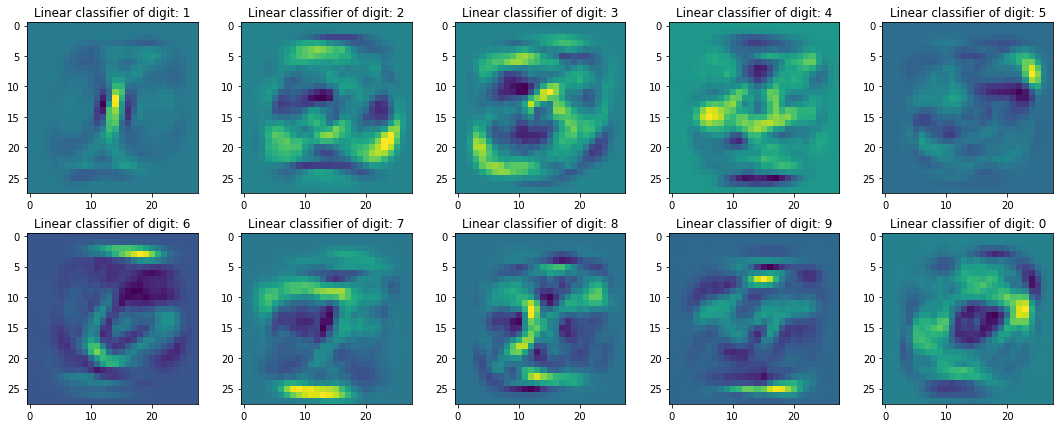

In [15]:
# plot images
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(3*num_col,3*num_row))

nr, nc = w.shape
IM = np.zeros((28,28))


for i in range(nc):
  if i == nc-1:
    ii = 0
  else:
    ii = i+1
  v_aux = (w[1:,i]-np.ndarray.min(w[1:,i]))/(np.ndarray.max(w[1:,i])-np.ndarray.min(w[1:,i]))
  ind = 0
  for j in range(28):
    for k in range(28):
      IM[k,j] = v_aux[ind]
      ind+=1
  ax = axes[i//num_col, i%num_col]
  ax.imshow(IM)
  ax.set_title('Linear classifier of digit: {}'.format(ii))
plt.tight_layout()
plt.show()

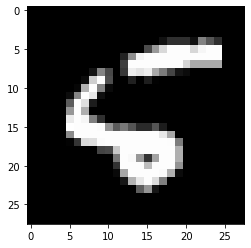

In [70]:
# plot the sample
Xt_plot = Xt[:,1:].reshape(10000, 28, 28)
sample = 8
image = Xt_plot[sample].T
fig = plt.figure

plt.imshow(image, cmap='gray')
plt.show()

In [17]:
S_est_t[:5,:]

array([[-0.03884791,  0.10399464,  0.11562564, -0.07318516, -0.02847723,
        -0.04907165,  0.81110772, -0.06215822,  0.05954352,  0.0248475 ],
       [-0.12764097,  0.60302748,  0.12552128, -0.29421556,  0.19385376,
         0.32201964, -0.09063128,  0.04761901, -0.06090599,  0.17536327],
       [ 0.68295288,  0.03454218,  0.02119101,  0.03119873,  0.01838925,
         0.03283357,  0.05445821, -0.04073191,  0.00412028,  0.00596196],
       [-0.01292955,  0.0462847 , -0.03943886, -0.15542409,  0.08250294,
         0.18596004,  0.20951476, -0.05246941, -0.00729594,  0.78758358],
       [-0.00759742,  0.12210271, -0.00259275,  0.46888294,  0.00555115,
         0.04281732,  0.06855536,  0.0316472 ,  0.11558526, -0.04771822]])

In [49]:
one_hot_predictions = np.zeros((S_est_t.shape), dtype=int)
for i in range(S_est_t.shape[0]):
  max_i = np.argmax(S_est_t[i,:], axis=0)
  one_hot_predictions[i, max_i] = 1

print('Check if the first five elements converges')
print('Predictions:\n', one_hot_predictions[:5,:])
print('Labels:\n', St[:5,:])

Check if the first five elements converges
Predictions:
 [[0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]]
Labels:
 [[0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 1 0 0 0 0 0 0]]


In [30]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(St.argmax(axis=1), one_hot_predictions.argmax(axis=1), labels=[1,2,3,4,5,6,7,8,9,0])
cf_matrix

array([[ 818,   18,   13,    0,   22,   28,   35,    5,   19,   74],
       [  25,  886,    3,   11,   10,   30,   17,    7,    5,   16],
       [   5,    0,  883,    1,   11,    1,    9,   47,    1,   24],
       [   7,   99,   29,  600,   26,   22,   55,   18,   20,   16],
       [   6,    0,   15,   16,  892,    0,    4,    0,   16,    9],
       [  18,    7,   16,    0,    3,  894,    1,   41,    4,   44],
       [   9,   32,   20,   20,   20,   16,  764,   20,   13,   60],
       [   2,   15,   65,    3,    3,   61,    6,  818,   22,   14],
       [   1,    2,    1,    7,   18,    1,    7,    0,  943,    0],
       [   2,    2,    1,    1,    5,    1,   15,    0,    0, 1108]])

In [31]:
np.trace(cf_matrix)/S_est_t.shape[0]

0.8606

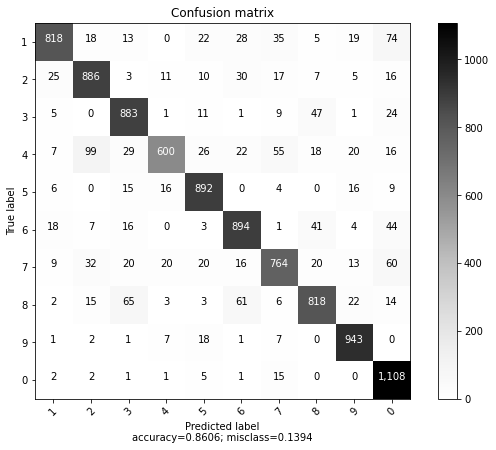

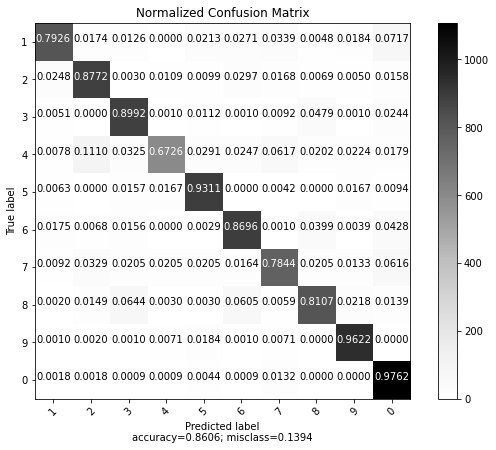

In [45]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cf_matrix, cmap='Greys', target_names=['1','2','3','4','5','6','7','8','9','0'], normalize=False)


plot_confusion_matrix(cf_matrix, title='Normalized Confusion Matrix',cmap='Greys', target_names=['1','2','3','4','5','6','7','8','9','0'], normalize=True)

### Dígitos mais desafiadores pro classificador:
Dígito 4 e dígito 7.

In [69]:
true_class = np.argmax(St[8,:], axis=0)
print(true_class)

pred_class = np.argmax(one_hot_predictions[8,:], axis=0)
pred_class

4


3

In [58]:
indexes = []
for i in range(St.shape[0]):
  true_class = np.argmax(St[i,:], axis=0)
  pred_class = np.argmax(one_hot_predictions[i,:], axis=0)
  if true_class != pred_class:
    indexes.append(i)

indexes[:5]

[8, 11, 33, 38, 43]

In [65]:
indexes[:10]

[8, 11, 33, 38, 43, 45, 46, 63, 66, 77]

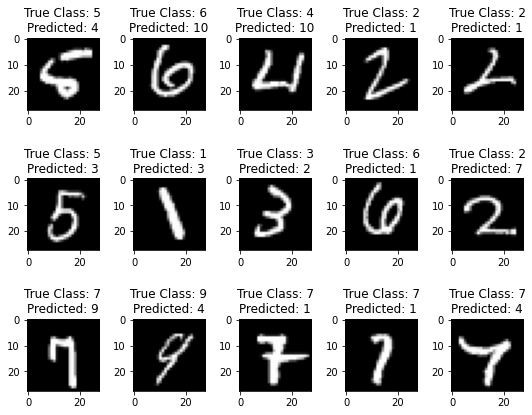

In [79]:
num = 15 # Number of samples to visualize
# X_plot = Xt_plot.reshape(60000, 28, 28)
# sample = 8
# image = Xt_plot[sample].T

predicted = np.argmax(one_hot_predictions, axis=1) +1
predicted = np.where(labels==10, 0, predicted)

labels = np.argmax(St, axis=1) + 1
labels = np.where(labels==10, 0, labels)

num_row = 3
num_col = 5
images = Xt_plot[indexes[:num]]
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i].T, cmap='gray')
    j = indexes[i]
    ax.set_title('True Class: {}\nPredicted: {}'.format(labels[j], predicted[j]))
plt.tight_layout()
plt.show()

In [76]:
images = Xt_plot[indexes[:num]]

images.shape

(10, 28, 28)

In [59]:
one_hot_predictions[8,:]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0])

In [60]:
St[8,:]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0], dtype=uint8)